In [5]:
# Import  all required modules and functions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() 
sns.set_style("darkgrid")

# Diable warnings
import warnings
warnings.filterwarnings('ignore')
# Imputing
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
# Scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler
# Ordinal
from sklearn.preprocessing import OrdinalEncoder
# OneHot
from sklearn.preprocessing import OneHotEncoder
# Bins
from sklearn.preprocessing import KBinsDiscretizer
#RBF
from sklearn.gaussian_process import GaussianProcessClassifier
# Customized transformer
from sklearn.preprocessing import FunctionTransformer
# Pipelines
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
# Column transformer
from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor
# Polynomial Features
from sklearn.preprocessing import PolynomialFeatures
# Train test split
from sklearn.model_selection import train_test_split
#Regression models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import PoissonRegressor
from sklearn.ensemble import RandomForestRegressor
# Roc-curve (AUC)
from sklearn.metrics import plot_roc_curve, roc_curve, auc
# Cross-validation
from sklearn.model_selection import cross_val_score
# Confusin matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
# Different scores
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import mean_squared_log_error, make_scorer, r2_score
# Hyperparameteroptimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit

# Prework

## Import data

In [6]:
df_bike = pd.read_csv('../data/train.csv', index_col=0, parse_dates=True)

In [7]:
df_bike.head(5)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [8]:
df_bike.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   casual      10886 non-null  int64  
 9   registered  10886 non-null  int64  
 10  count       10886 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 1020.6 KB


In [9]:
df_bike.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


## Define some global functions

In [10]:
# Define rmsle function for evaluation
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [11]:
# Transform rmsle fucntion into scorer 
rmsle_scorer = make_scorer(score_func=rmsle, greater_is_better=False)

In [12]:
# Function to print out results of the hyperparameter optimization
def print_results(cv_h, show_all = False):
    print('Best:')
    print(round(cv_h.best_score_, 3), ' for ', cv_h.best_params_)
    if show_all:
        print('All:')
        for mean, params in zip(cv_h.cv_results_['mean_test_score'], 
                                cv_h.cv_results_['params']):
                print('{}  for {}'.format(round(mean, 3), params))

# Add additional features

## Add time related features

In [13]:
df_bike = df_bike.reset_index()

In [14]:
# Year
df_bike['year'] = df_bike['datetime'].apply(lambda x: x.year)

In [15]:
# Month
df_bike['month'] = df_bike['datetime'].apply(lambda x: x.month)

In [16]:
# Day of the week
df_bike['day'] = df_bike['datetime'].apply(lambda x: x.isoweekday())

In [17]:
# Hour within day
df_bike['hour'] = df_bike['datetime'].apply(lambda x: x.hour)

In [18]:
df_bike = df_bike.set_index('datetime')

In [19]:
# Open question: why is this not working
#df_bike['hour'] = df_bike.reset_index().loc[:,'datetime'].apply(lambda x: x.hour)
#df_bike.head()

## Add 'rolling' mean/min/max features

In [20]:
# mean of temp of previous 3 and 12 hours
df_bike['temp_mean_3'] = df_bike['temp'].rolling(3).mean().fillna(method='bfill')
df_bike['temp_mean_12'] = df_bike['temp'].rolling(12).mean().fillna(method='bfill')

In [21]:
# max of weather of previous 3 and 12 hours
df_bike['weather_max_3'] = df_bike['weather'].rolling(3).max().fillna(method='bfill')
df_bike['weather_max_12'] = df_bike['weather'].rolling(12).max().fillna(method='bfill')

In [22]:
# min of weather of previous 3 and 12 hours
df_bike['weather_min_3'] = df_bike['weather'].rolling(3).min().fillna(method='bfill')
df_bike['weather_min_12'] = df_bike['weather'].rolling(12).min().fillna(method='bfill')

In [23]:
# mean of wind of previous 3 and 12 hours
df_bike['windspeed_mean_3'] = df_bike['windspeed'].rolling(3).mean().fillna(method='bfill')
df_bike['windspeed_mean_12'] = df_bike['windspeed'].rolling(12).mean().fillna(method='bfill')

# Explorative data analysis

In [24]:
df_bike.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,...,day,hour,temp_mean_3,temp_mean_12,weather_max_3,weather_max_12,weather_min_3,weather_min_12,windspeed_mean_3,windspeed_mean_12
datetime,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,...,6,0,9.293333,10.66,1.0,2.0,1.0,1.0,0.0,3.500192
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,...,6,1,9.293333,10.66,1.0,2.0,1.0,1.0,0.0,3.500192
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,...,6,2,9.293333,10.66,1.0,2.0,1.0,1.0,0.0,3.500192
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,...,6,3,9.293333,10.66,1.0,2.0,1.0,1.0,0.0,3.500192
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,...,6,4,9.566667,10.66,1.0,2.0,1.0,1.0,0.0,3.500192


## Check correlation of features

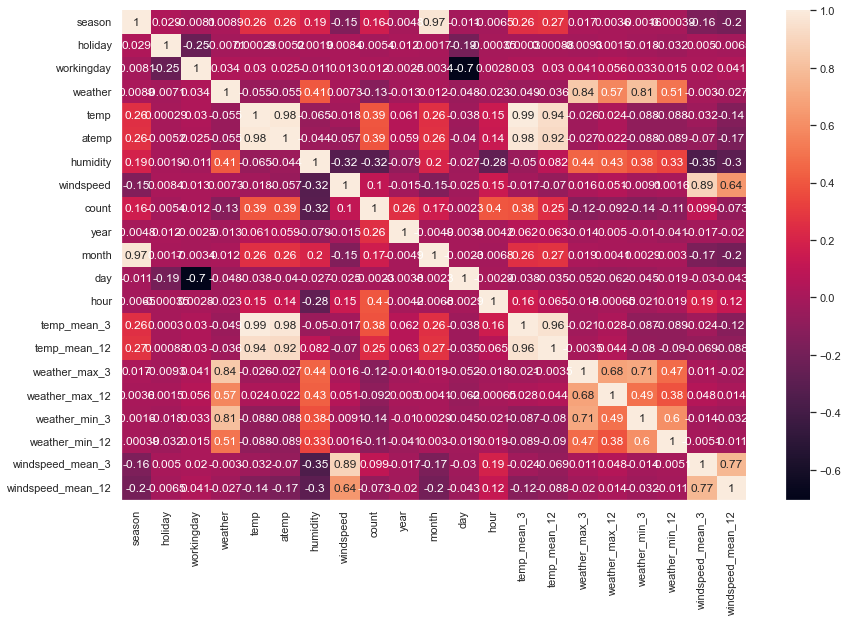

In [25]:
plt.figure(figsize=(14,9))
sns.heatmap(df_bike.drop(['casual', 'registered'], axis = 1).corr(), annot=True)
sns.despine()

__We can drop some features from the data set:__
* `'workingday'`: Is an aggreagtion of 'holiday' and 'day'
* `'season'`: Is strongley correlated to 'month'
* `'atemp'`: Is strongly correlated to temperature
* `xxx_mean/min/max_3`: Overall these values strongly correlated, will only keep mean_12 features

In [26]:
# Drop 'workingday' and 'season'
df_bike = df_bike.drop(['workingday', 'season', 'atemp', 
                        'temp_mean_3', 'weather_min_3', 'weather_max_3',
                        'windspeed_mean_3'], 
                       axis = 1)

## Analyze "means of counts" per time

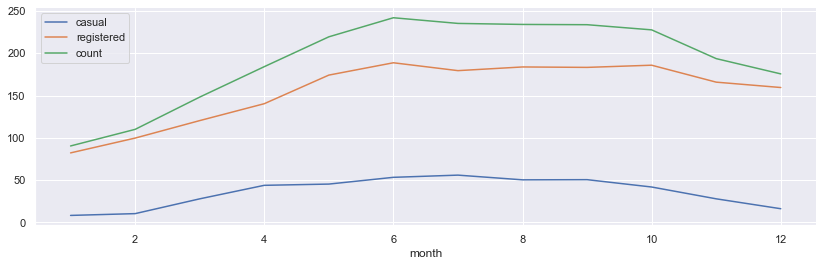

In [23]:
# Means of count per month 
df_bike.groupby('month')[['casual', 'registered', 'count']].mean().plot(figsize=(14,4))
sns.despine()

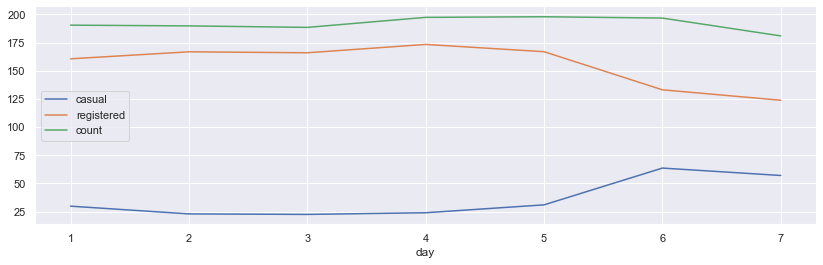

In [24]:
# Means of count per day 
df_bike.groupby('day')[['casual', 'registered', 'count']].mean().plot(figsize=(14,4))
sns.despine()

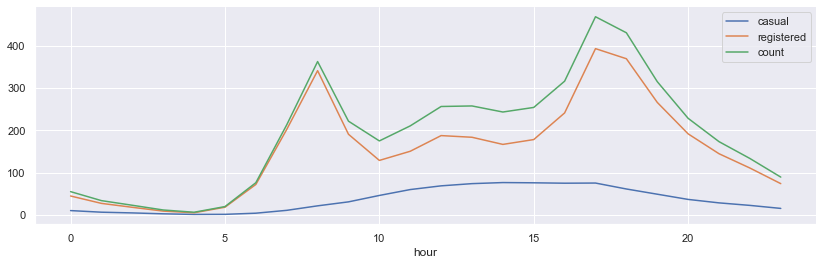

In [25]:
# Means of count per hour
df_bike.groupby('hour')[['casual', 'registered', 'count']].mean().plot(figsize=(14,4))
sns.despine()

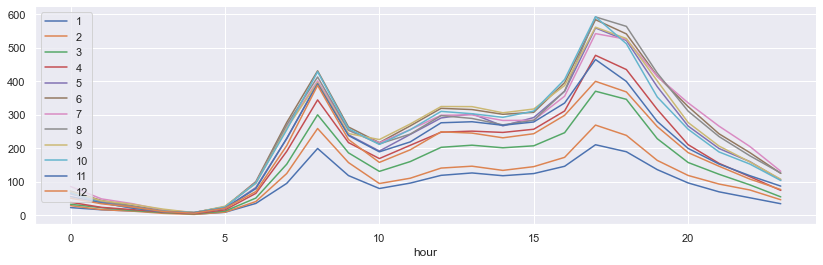

In [26]:
# Means of count per day over months
data = pd.DataFrame()
for month in range(1,13):
    data[month] = df_bike[df_bike['month'] == month].groupby('hour')['count'].mean()
   
data.plot(figsize=(14,4))
sns.despine()

## Analyze impact of selected variables on count

### Weather / ambient conditions

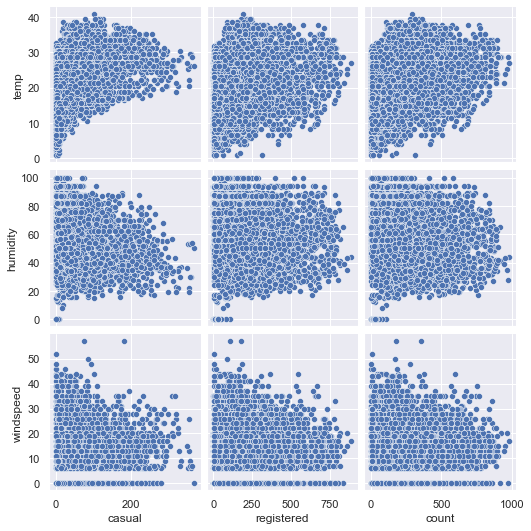

In [27]:
sns.pairplot(data = df_bike,
             x_vars = ['casual', 'registered', 'count'],
             y_vars = ['temp', 'humidity', 'windspeed'])
sns.despine()

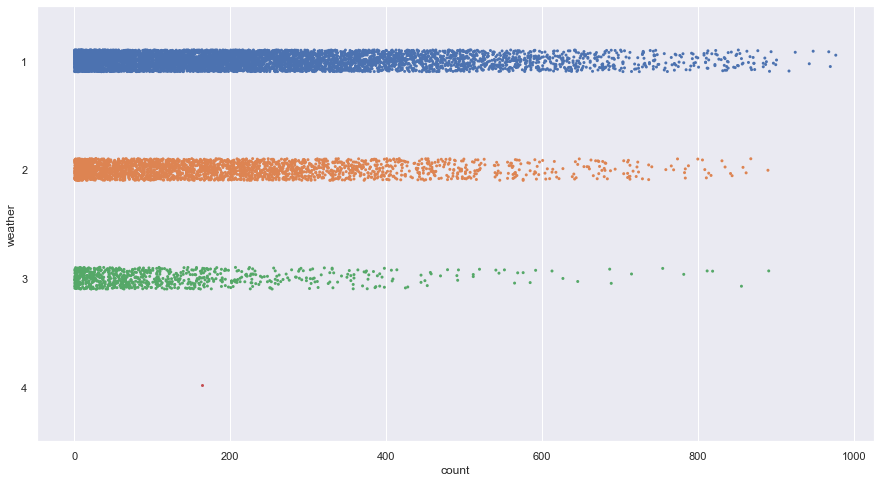

In [28]:
# Counts depending on 'weather' (1/2)
plt.figure(figsize=(15,8))
ax = sns.stripplot(x=df_bike['count'], y=df_bike['weather'].astype(str), size = 3)
#ax.set(ylabel="")
plt.show()

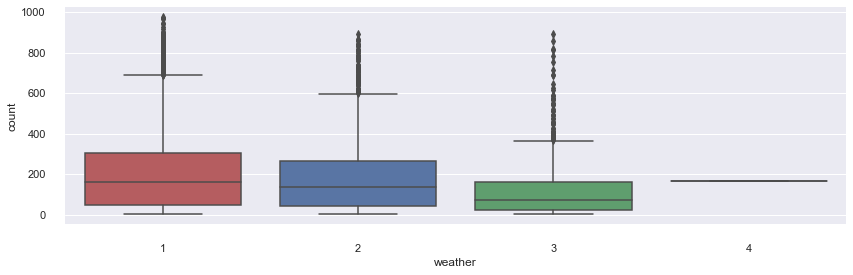

In [29]:
# Counts depending on 'weather' (2/2)
# 1 =. good -> 4 = very bad
plt.figure(figsize=(14,4))
sns.boxplot(data = df_bike, 
            x='weather', y='count',
            palette=['r', 'b', 'g', 'y'])
sns.despine(offset=10, trim=True)

### Other variables

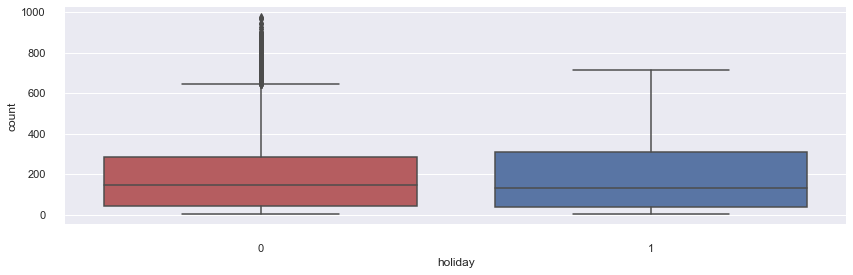

In [30]:
# Counts depending on holiday
# 1 = holiday
plt.figure(figsize=(14,4))
sns.boxplot(data = df_bike, 
            x='holiday', y='count',
            palette=['r', 'b', 'g', 'y'])
sns.despine(offset=10, trim=True)

# Linear regression

## Split data

In [44]:
# Define X and y
X = df_bike.drop(['casual', 'registered', 'count'], axis = 1)
y = df_bike['count']

In [45]:
#Train-test-split for casual bike shares
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                            test_size = 0.2, 
                                                            random_state = 297)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8708, 13), (2178, 13), (8708,), (2178,))

## Engineer features

_Numeric columns to be scaled, categorical columns to be onehot encoded, use of polynomial features_

### Define pipelines

In [46]:
# Scaling for numeric variables
num_pipe = make_pipeline(
    MinMaxScaler()
)

In [47]:
# One_hot_encoding for categorical variables
cat_pipe = make_pipeline(
    OneHotEncoder(handle_unknown = 'ignore')
)

In [48]:
# Prepare tables for RBF encoding - not implemented
def rbf(x, width, mean):
    """calculates a single RBF peak"""
    return np.exp(-(x - mean)**2 / (2 * width))

def rbf_transform(df, freq, width):
    """creates repeating seasonal RBF peaks"""
    n_values = df.shape[0]
    x = np.arange(n_values)
    for i in range(0, freq):
        df[f'rbf_{i}'] = 0
        for j in range(-freq, n_values+freq, freq):
            df[f'rbf_{i}'] += rbf(x, width, j + i)
    return df

# Create tabel for month and hour encoding
df_month = rbf_transform(pd.DataFrame(range(12)), 12, 5)  
df_hour = rbf_transform(pd.DataFrame(range(24)), 24, 5) 

In [49]:
# Create rbf encoding for months - not implemented
def rbf_month(df): 
    df = pd.DataFrame(df)     
    selection = range(1,13) # range can be adjusted - range(1,13) is similar to onehot-encoding
    
    rbf_series = None
    
    for i in selection: 
        if i == 1:
            rbf_series = df.iloc[:, 0].apply(lambda x: df_month.iloc[x-1, i])
        else:
            rbf_series_new = df.iloc[:, 0].apply(lambda x: df_month.iloc[x-1, i])
            rbf_series = pd.concat([rbf_series, rbf_series_new], axis = 1)
    
    return rbf_series.values.reshape(-1, len(selection))
    
rbf_month_pipe = make_pipeline(
    FunctionTransformer(rbf_month)
)

# Test
#rbf_month_pipe.fit_transform(pd.DataFrame([12]))

In [50]:
# Create rbf encoding for hours - not implemented
def rbf_hour(df): 
    df = pd.DataFrame(df)     
    selection = range(1, 25)
    
    rbf_series = None
    
    for i in selection: # range can be adjusted - full range similar to onehot-encoding
        if i == 1:
            rbf_series = df.iloc[:, 0].apply(lambda x: df_hour.iloc[x, i])
        else:
            rbf_series_new = df.iloc[:, 0].apply(lambda x: df_hour.iloc[x, i])
            rbf_series = pd.concat([rbf_series, rbf_series_new], axis = 1)
    
    return rbf_series.values.reshape(-1, len(selection))
    
rbf_hour_pipe = make_pipeline(
    FunctionTransformer(rbf_hour)
)

# Test
#rbf_hour_pipe.fit_transform(df_bike[['hour']])
#pd.DataFrame(rbf_hour_pipe.fit_transform(pd.DataFrame([1, 7, 23])))

In [51]:
# How to implement customized functions

'''

def function(df):
    
    # save passed data as dataframe
    df = pd.DataFrame(df)
    
    # function 1
    helper_list = df.iloc[:, 0].apply(lambda x: ...)
    
    # function 2
    ...
    
    # Concat both results and send as back as numpy array        
    merged_data = pd.concat([helper_list1, helper_list2, ...], axis = 1)
    
    # Write list of column names ('column names' should be global variable)
    column_names.append('helper1', 'helper2', ...)
    
    return merged_data.values.reshape(-1, # of functions)

 
pipeline = make_pipeline(
    FunctionTransformer(function)
)


''';


### Summarize in column transformer

In [52]:
df_bike.head(1)

,holiday,weather,temp,humidity,windspeed,casual,registered,count,year,month,day,hour,temp_mean_12,weather_max_12,weather_min_12,windspeed_mean_12
datetime,,,,,,,,,,,,,,,,
2011-01-01,0,1,9.84,81,0.0,3,13,16,2011,1,6,0,10.66,2.0,1.0,3.500192


In [53]:
# Defining the "preprocessor"
feature_transform = ColumnTransformer([
    ('do_nothing', 'passthrough', ['holiday']), 
    ('one_hot_encoding', cat_pipe, ['weather', 'weather_max_12', 'weather_min_12', 
                                    'year', 'month', 'day', 'hour']),
    #('rbf_month_encoding', rbf_month_pipe, ['month']),
    #('rbf_hour_encoding', rbf_hour_pipe, ['hour']),
    ('num_scaling', num_pipe, ['temp', 'temp_mean_12', 'humidity', 'windspeed', 'windspeed_mean_12'])
])

In [54]:
def get_column_names_from_ColumnTransformer(column_transformer):    
    col_name = []

    for transformer_in_columns in column_transformer.transformers_[:-1]: #the last transformer is ColumnTransformer's 'remainder'
        #print('\n\ntransformer: ', transformer_in_columns[0])
        
        raw_col_name = list(transformer_in_columns[2])
        
        if isinstance(transformer_in_columns[1], Pipeline): 
            # if pipeline, get the last transformer
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
            
        try:
          if isinstance(transformer, OneHotEncoder):
            names = list(transformer.get_feature_names(raw_col_name))
            
          elif isinstance(transformer, SimpleImputer) and transformer.add_indicator:
            missing_indicator_indices = transformer.indicator_.features_
            missing_indicators = [raw_col_name[idx] + '_missing_flag' for idx in missing_indicator_indices]

            names = raw_col_name + missing_indicators
            
          else:
            names = list(transformer.get_feature_names())
          
        except AttributeError as error:
          names = raw_col_name
        
        #print(names)    
        
        col_name.extend(names)
            
    return col_name

In [55]:
# This only works after the model has been trained! (function not availble when working with Anaconda)
#feature_columns = get_column_names_from_ColumnTransformer(feature_transform)
#feature_columns

## Create regression model

In [56]:
# Create regression model
rgr_ln = Pipeline(steps=[
            ('preprocessor', feature_transform),
            ('poly_features', PolynomialFeatures(degree=2, 
                                                 include_bias=False, 
                                                 interaction_only=False)),
            ('m_ln', LinearRegression())
])

# Implement target transformation
rgr_ln_t = TransformedTargetRegressor(regressor=rgr_ln, func=np.log1p, inverse_func=np.expm1)

In [57]:
# Impact of transformation on data shape/size
import scipy.sparse

X_train_1 = pd.DataFrame.sparse.from_spmatrix(feature_transform.fit_transform(X_train))
poly_transform = PolynomialFeatures(degree=2, 
                                    include_bias=False, 
                                    interaction_only=True)
X_train_2 = pd.DataFrame.sparse.from_spmatrix(poly_transform.fit_transform(X_train_1))

print('Before transformation:    ', X_train.shape)
print('After feature_transform:  ', X_train_1.shape)
print('After polynomialfeatures: ', X_train_2.shape)

Before transformation:     (8708, 13)
After feature_transform:   (8708, 62)
After polynomialfeatures:  (8708, 1953)


In [58]:
#rgr_ln_t.fit(X_train, y_train);
rgr_ln_t.fit(X_train, y_train);

## Evaluate regression model

_2 metrics used (R2 & RMSLE), RMSLE used for Kaggle competition_

### Using R2

In [59]:
r2_train = round(rgr_ln_t.score(X_train, y_train), 3)
print(f'R2 for train dataset: {r2_train}')

R2 for train dataset: 0.956


In [60]:
r2_test = round(rgr_ln_t.score(X_test, y_test), 3)
print(f'R2 for test dataset: {r2_test}')

R2 for test dataset: 0.947


In [61]:
# Cross validation with R2 as scorer
cross_val_r2 = cross_val_score(rgr_ln_t, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
cross_val_r2

array([0.93750671, 0.93559236, 0.93202331, 0.94741927, 0.93776716])

In [62]:
# Mean R2 from cross-validation
round(cross_val_r2.mean(),3)

0.938

### Using RMSLE

In [63]:
#Get predictions for train and test dataset
y_pred_train = rgr_ln_t.predict(X_train)
y_pred_test = rgr_ln_t.predict(X_test)

In [64]:
# RMSLE for train set
RMSLE_train = round(rmsle(y_train, y_pred_train), 3)
print(f'RMSLE for train dataset: {RMSLE_train}')

RMSLE for train dataset: 0.253


In [65]:
# RMSLE for train set
RMSLE_test = round(rmsle(y_test, y_pred_test), 3)
print(f'RMSLE for test dataset: {RMSLE_test}')

RMSLE for test dataset: 0.289


In [66]:
# Cross-validation with RMSLE as scorer (cv = shs -> random sampling)
shs = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
cross_val_rmsle = -1 * cross_val_score(rgr_ln_t, X_train, y_train, 
                                       cv=shs, scoring=rmsle_scorer,
                                       n_jobs=-1)#, error_score="raise")
cross_val_rmsle

array([0.33424862, 0.30380169, 0.32689449, 0.29260256, 0.30836338])

In [67]:
# Mean RMSLE from cross-validation
round(cross_val_rmsle.mean(), 3)

0.313

In [68]:
# Random cross-validation with RMSLE as scorer (for comparison with 2 modell approach)

# Make sure to use original train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 297)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

rmsle_list = []

for i in [12, 24, 44, 233, 53]:
    
    #Split the data set
    X_trn, X_tst, y_trn, y_tst = train_test_split(X_train, y_train, test_size=0.2, random_state=i)
    
    # Train the 2 models
    rgr_ln_t.fit(X_trn, y_trn)
    
    # Predict outcomes separately
    y_pred_tst = rgr_ln_t.predict(X_tst)
    
    # Calculate RMSLE score
    rmsle_i = rmsle(y_tst, y_pred_tst)
    
    # Save result
    rmsle_list.append(rmsle_i)
    
# Print results
print('List of results: ', [round(i, 3) for i in rmsle_list])
print('Mean value: ', round(np.mean(rmsle_list), 3))

List of results:  [0.308, 0.311, 0.295, 0.301, 0.297]
Mean value:  0.302


### Check predictions vs. true values

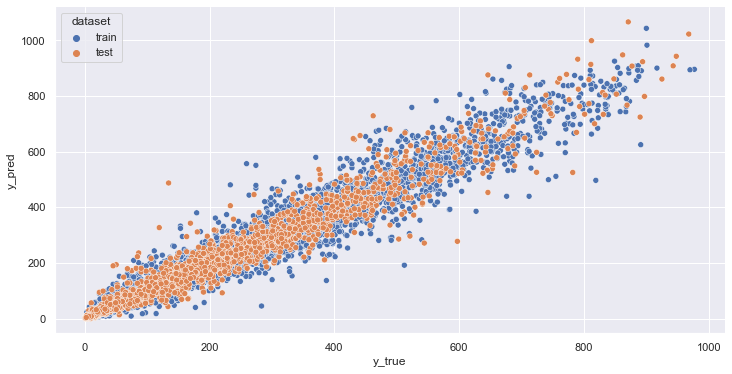

In [69]:
# Draw scatterplot of predictions vs. true values
df_res = pd.DataFrame(y_train)
df_res['y_pred']=y_pred_train
df_res['dataset']='train'
df_res.rename(columns = {'count' : 'y_true'}, inplace = True)

df_res2 = pd.DataFrame(y_test)
df_res2['y_pred']=y_pred_test
df_res2['dataset']='test'
df_res2.rename(columns = {'count' : 'y_true'}, inplace = True)

df_res = pd.concat([df_res, df_res2], ignore_index=True, sort=False)

#sns.relplot(x='y_true', y='y_pred', data=df_res, col='dataset', hue='dataset',height = 4)
plt.figure(figsize=(12,6))
sns.scatterplot(x='y_true', y='y_pred', hue='dataset', data=df_res)
sns.despine()


# Poisson regression

## Split data

In [70]:
# Define X and y
X = df_bike.drop(['casual', 'registered', 'count'], axis = 1)
y = df_bike['count']

In [71]:
#Train-test-split for casual bike shares
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 297)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8708, 13), (2178, 13), (8708,), (2178,))

## Engineer features

_Same feature engineering as for linear regression_

## Create regression model

In [72]:
rgr_pos = Pipeline(steps=[
    ('preprocessor', feature_transform),
    ('poly_features', PolynomialFeatures(degree=2, 
                                         include_bias=False,
                                         interaction_only=False)),
    #('MaxAbsScaler', MaxAbsScaler()),
    ('m_pos', PoissonRegressor(alpha=0))
])

In [73]:
rgr_pos.fit(X_train, y_train);

In [74]:
round(rgr_pos.score(X_train, y_train), 3), round(rgr_pos.score(X_test, y_test), 3)

(0.967, 0.96)

## Evaluate regression model

_2 metrics used (R2 & RMSLE), RMSLE used for Kaggle competition_

### Using R2

In [75]:
r2_train = round(rgr_pos.score(X_train, y_train), 3)
print(f'R2 for train dataset: {r2_train}')

R2 for train dataset: 0.967


In [76]:
r2_test = round(rgr_pos.score(X_test, y_test), 3)
print(f'R2 for test dataset: {r2_test}')

R2 for test dataset: 0.96


In [77]:
# Cross validation with R2 as scorer
cross_val_r2 = cross_val_score(rgr_pos, X_train, y_train, 
                               cv=5, scoring='r2',
                               n_jobs=-1);
cross_val_r2

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale 

array([0.95226875, 0.94974417, 0.94735057, 0.95537684, 0.94928429])

In [78]:
# Mean R2 from cross-validation
round(cross_val_r2.mean(),3)

0.951

### Using RMSLE

In [79]:
#Get predictions for train and test dataset
y_pred_train = rgr_pos.predict(X_train)
y_pred_test = rgr_pos.predict(X_test)

In [80]:
# RMSLE for train set
RMSLE_train = round(rmsle(y_train, y_pred_train), 3)
print(f'RMSLE for train dataset: {RMSLE_train}')

RMSLE for train dataset: 0.318


In [81]:
# RMSLE for train set
RMSLE_test = round(rmsle(y_test, y_pred_test), 3)
print(f'RMSLE for test dataset: {RMSLE_test}')

RMSLE for test dataset: 0.346


In [82]:
# With RMSLE as scorer
cross_val_rmsle = -1 * cross_val_score(rgr_pos, X_train, y_train, cv=5, scoring=rmsle_scorer) #error_score="raise")
cross_val_rmsle

array([0.33732357, 0.3403715 , 0.34632749, 0.34648206, 0.34620004])

In [83]:
# Mean RMSLE from cross-validation
round(cross_val_rmsle.mean(), 3)

0.343

### Check predictions vs. true values

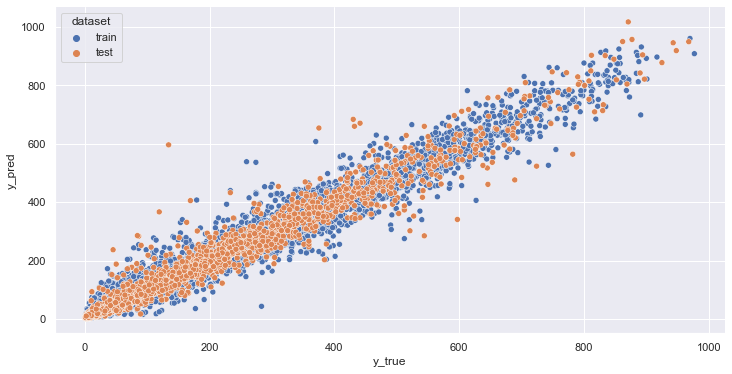

In [84]:
# Draw scatterplot of predictions vs. true values
df_res = pd.DataFrame(y_train)
df_res['y_pred']=y_pred_train
df_res['dataset']='train'
df_res.rename(columns = {'count' : 'y_true'}, inplace = True)

df_res2 = pd.DataFrame(y_test)
df_res2['y_pred']=y_pred_test
df_res2['dataset']='test'
df_res2.rename(columns = {'count' : 'y_true'}, inplace = True)

df_res = pd.concat([df_res, df_res2], ignore_index=True, sort=False)

#sns.relplot(x='y_true', y='y_pred', data=df_res, col='dataset', hue='dataset',height = 4)
plt.figure(figsize=(12,6))
sns.scatterplot(x='y_true', y='y_pred', hue='dataset', data=df_res)
sns.despine()


# RandomForest Regression

## Split data

In [85]:
# Define X and y
X = df_bike.drop(['casual', 'registered', 'count'], axis = 1)
y = df_bike['count']

In [86]:
#Train-test-split for casual bike shares
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                            test_size = 0.2, 
                                                            random_state = 297)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8708, 13), (2178, 13), (8708,), (2178,))

## Engineer features

_Not required for RandomForest regression_

## Create model

In [87]:
rgr_rf = TransformedTargetRegressor(regressor=RandomForestRegressor(), 
                                               func=np.log1p, inverse_func=np.expm1)


In [88]:
rgr_rf.fit(X_train, y_train);

In [89]:
y_pred_train = rgr_rf.predict(X_train)
y_pred_test = rgr_rf.predict(X_test)

In [90]:
# R2 for train and test data
round(r2_score(y_train, y_pred_train),3), round(r2_score(y_test, y_pred_test),3)

(0.991, 0.949)

In [91]:
# RMSLE for train and test data
round(rmsle(y_train, y_pred_train), 3), round(rmsle(y_test, y_pred_test), 3)

(0.116, 0.306)

## Optimize hyperparameters

In [92]:
rgr_rf.get_params().keys()

dict_keys(['check_inverse', 'func', 'inverse_func', 'regressor__bootstrap', 'regressor__ccp_alpha', 'regressor__criterion', 'regressor__max_depth', 'regressor__max_features', 'regressor__max_leaf_nodes', 'regressor__max_samples', 'regressor__min_impurity_decrease', 'regressor__min_impurity_split', 'regressor__min_samples_leaf', 'regressor__min_samples_split', 'regressor__min_weight_fraction_leaf', 'regressor__n_estimators', 'regressor__n_jobs', 'regressor__oob_score', 'regressor__random_state', 'regressor__verbose', 'regressor__warm_start', 'regressor', 'transformer'])

### RandomGrid

In [93]:
random_grid = {
    'regressor__n_estimators' : [50, 100, 200, 400],
    'regressor__max_depth' : [5, 10, 50, None],
    'regressor__max_features': ['auto', 'sqrt', 'log2'],
    'regressor__min_samples_leaf' : [1, 0.05, 0.1],
    'regressor__bootstrap' : [True, False]
}

In [94]:
cv_rnd_h = RandomizedSearchCV(estimator=rgr_rf, 
                              param_distributions=random_grid,
                              scoring=rmsle_scorer,
                              n_iter=100, cv=3, n_jobs=-1,)

In [95]:
cv_rnd_h.fit(X_train, y_train);

In [96]:
# Print results of hyperparameter optimization using random search       
print_results(cv_rnd_h, False)

Best:
-0.357  for  {'regressor__n_estimators': 100, 'regressor__min_samples_leaf': 1, 'regressor__max_features': 'auto', 'regressor__max_depth': 10, 'regressor__bootstrap': True}


In [97]:
rgr_rf_best = cv_rnd_h.best_estimator_

### GridSearch

In [98]:
# Define parameters for hyperparameter optimization via GridSearch
parameters = {
    'regressor__n_estimators' : [50, 100, 200, 300, 400, 500],
    'regressor__max_depth' : [5, 50, 100, None],
}

In [99]:
cv_grd_h = GridSearchCV(estimator=rgr_rf_best, 
                       param_grid=parameters, 
                       cv=3, scoring=rmsle_scorer,
                       n_jobs=-1)

In [100]:
cv_grd_h.fit(X_train, y_train);

In [101]:
# Print results of hyperparameter optimization using grid search                
print_results(cv_grd_h, True)

Best:
-0.324  for  {'regressor__max_depth': 100, 'regressor__n_estimators': 400}
All:
-0.556  for {'regressor__max_depth': 5, 'regressor__n_estimators': 50}
-0.553  for {'regressor__max_depth': 5, 'regressor__n_estimators': 100}
-0.552  for {'regressor__max_depth': 5, 'regressor__n_estimators': 200}
-0.553  for {'regressor__max_depth': 5, 'regressor__n_estimators': 300}
-0.554  for {'regressor__max_depth': 5, 'regressor__n_estimators': 400}
-0.554  for {'regressor__max_depth': 5, 'regressor__n_estimators': 500}
-0.329  for {'regressor__max_depth': 50, 'regressor__n_estimators': 50}
-0.325  for {'regressor__max_depth': 50, 'regressor__n_estimators': 100}
-0.325  for {'regressor__max_depth': 50, 'regressor__n_estimators': 200}
-0.325  for {'regressor__max_depth': 50, 'regressor__n_estimators': 300}
-0.324  for {'regressor__max_depth': 50, 'regressor__n_estimators': 400}
-0.325  for {'regressor__max_depth': 50, 'regressor__n_estimators': 500}
-0.332  for {'regressor__max_depth': 100, 'reg

In [102]:
# Define best rf regression model (here manually based on long table of results, complexity vs. score)
rgr_rf_best = TransformedTargetRegressor(regressor=RandomForestRegressor(n_estimators=200, max_depth=100), 
                                               func=np.log1p, inverse_func=np.expm1)
# rgr_rf_best = cv_grd_h.best_estimator_

## Evaluate model

### Using R2

_Skipped_

### Using RMSLE

In [103]:
# Fit rgr-modell and get prediction from optimized model
rgr_rf_best.fit(X_train, y_train)
y_pred_train = rgr_rf_best.predict(X_train)
y_pred_test = rgr_rf_best.predict(X_test)

In [104]:
# With RMSLE as scorer
cross_val_rmsle = -1 * cross_val_score(rgr_rf_best, 
                                       X_train, y_train, 
                                       cv=5, scoring=rmsle_scorer,
                                       n_jobs=-1)
cross_val_rmsle

array([0.29539551, 0.31575425, 0.32617535, 0.30816373, 0.34235998])

In [105]:
# Mean RMSLE from cross-validation and RMSLE for test data
round(cross_val_rmsle.mean(), 3), round(rmsle(y_test, y_pred_test), 3)

(0.318, 0.303)

### Check predictions vs. true values

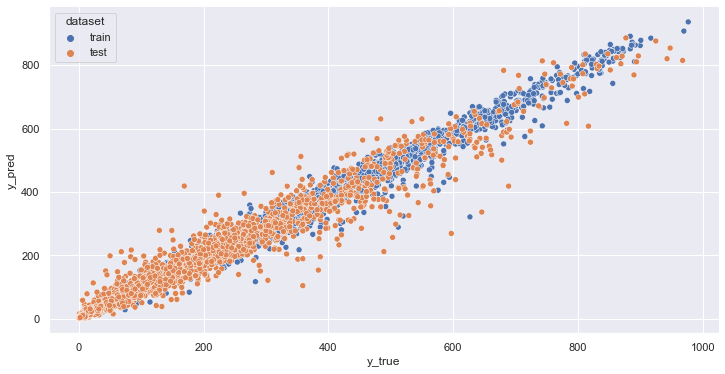

In [106]:
# Draw scatterplot of predictions vs. true values

df_res = pd.DataFrame(y_train)
df_res['y_pred']=y_pred_train
df_res['dataset']='train'
df_res.rename(columns = {'count' : 'y_true'}, inplace = True)

df_res2 = pd.DataFrame(y_test)
df_res2['y_pred']=y_pred_test
df_res2['dataset']='test'
df_res2.rename(columns = {'count' : 'y_true'}, inplace = True)

df_res = pd.concat([df_res, df_res2], ignore_index=True, sort=False)

#sns.relplot(x='y_true', y='y_pred', data=df_res, col='dataset', hue='dataset',height = 4)
plt.figure(figsize=(12,6))
sns.scatterplot(x='y_true', y='y_pred', hue='dataset', data=df_res)
sns.despine()

### Feature importance

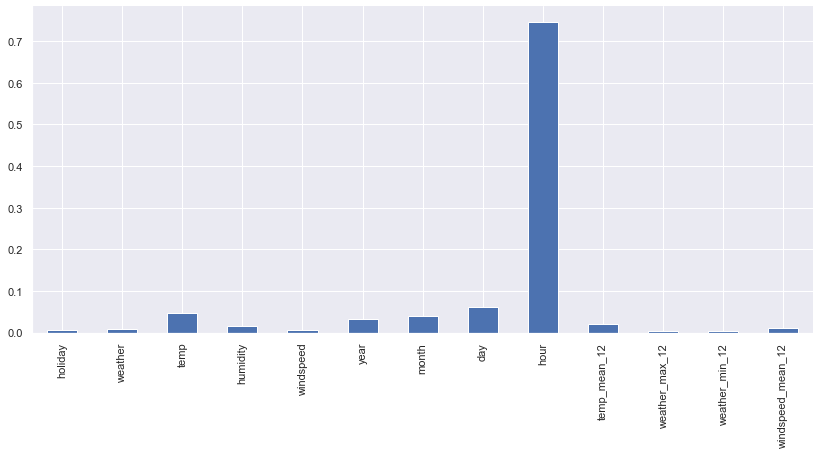

In [107]:
# Analyze feature importance
importance = pd.DataFrame(rgr_rf_best.regressor_.feature_importances_)
importance.index = X.columns
importance.sort_values(by = 0, ascending = False).head(10)

importance.plot.bar(legend=False, figsize=(14,6))
sns.despine()

# Linear Regression (separate models for casual and registered)

## Split data and transform y

In [108]:
# Define X and y
X = df_bike.drop(['casual', 'registered', 'count'], axis = 1)
y_cas = df_bike['casual']
y_reg = df_bike['registered']
y = df_bike[['casual', 'registered', 'count']]

In [109]:
#Train-test-split for casual bike shares
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 297)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8708, 13), (2178, 13), (8708, 3), (2178, 3))

In [110]:
# Derive required target variables for 'casual' and 'registered' bike counts
y_cas_train = y_train['casual']
y_reg_train = y_train['registered']

y_cas_test = y_test['casual']
y_reg_test = y_test['registered']

y_train = y_train['count']
y_test = y_test['count']

## Engineer features

_Same feature engineering as for linear regression with one model_

## Create regression model

### Model for 'casual'

In [111]:
rgr_ln_cas = Pipeline(steps=[
    ('preprocessor', feature_transform),
    ('poly_features', PolynomialFeatures(degree=2, 
                                         include_bias=False,
                                         interaction_only=False)),
    ('m_ln_cas', LinearRegression()) 
])

rgr_ln_cas_t = TransformedTargetRegressor(regressor=rgr_ln_cas, func=np.log1p, inverse_func=np.expm1)

In [112]:
rgr_ln_cas_t.fit(X_train, y_cas_train);

In [113]:
round(rgr_ln_cas_t.score(X_train, y_cas_train), 3), round(rgr_ln_cas_t.score(X_test, y_cas_test), 3)

(0.904, 0.893)

### Model for 'registered'

In [114]:
rgr_ln_reg = Pipeline(steps=[
    ('preprocessor', feature_transform),
    ('poly_features', PolynomialFeatures(degree=2, 
                                         include_bias=False,
                                        interaction_only=False)),
    ('m_ln_reg', LinearRegression()) 
])

rgr_ln_reg_t = TransformedTargetRegressor(regressor=rgr_ln_reg, func=np.log1p, inverse_func=np.expm1)

In [115]:
rgr_ln_reg_t.fit(X_train, y_reg_train);

## Evaluate regression model

_2 metrics used (R2 & RMSLE), RMSLE used for Kaggle competition_

### Using R2 - casual counts

In [116]:
r2_train = round(rgr_ln_cas_t.score(X_train, y_cas_train), 3)
print(f'R2 for train dataset: {r2_train}')

R2 for train dataset: 0.904


In [117]:
r2_test = round(rgr_ln_cas_t.score(X_test, y_cas_test), 3)
print(f'R2 for test dataset: {r2_test}')

R2 for test dataset: 0.893


In [118]:
# Cross validation with R2 as scorer
cross_val_r2 = cross_val_score(rgr_ln_cas_t, X_train, y_cas_train, 
                               cv=5, scoring='r2',
                               n_jobs=-1)
cross_val_r2

array([0.85422009, 0.8719859 , 0.87351316, 0.86944743, 0.87748992])

In [119]:
# Mean R2 from cross-validation
round(cross_val_r2.mean(),3)

0.869

### Using R2 - registered counts

In [120]:
r2_train = round(rgr_ln_reg_t.score(X_train, y_reg_train), 3)
print(f'R2 for train dataset: {r2_train}')

R2 for train dataset: 0.958


In [121]:
r2_test = round(rgr_ln_reg_t.score(X_test, y_reg_test), 3)
print(f'R2 for test dataset: {r2_test}')

R2 for test dataset: 0.95


In [122]:
# Cross validation with R2 as scorer
cross_val_r2 = cross_val_score(rgr_ln_reg_t, X_train, y_reg_train, 
                               cv=5, scoring='r2',
                               n_jobs=-1)
cross_val_r2

array([0.94150807, 0.93790813, 0.93451383, 0.95307043, 0.94073084])

In [123]:
# Mean R2 from cross-validation
round(cross_val_r2.mean(),3)

0.942

### Using RMSLE - combined/counts

In [124]:
# Get predictions and ensure that all counts are non-negative (only for 'cas' model)
# casual
y_cas_pred_train = np.array([max(i, 0) for i in rgr_ln_cas_t.predict(X_train)])
y_cas_pred_test = np.array([max(i, 0) for i in rgr_ln_cas_t.predict(X_test)])
# registered
y_reg_pred_train = rgr_ln_reg_t.predict(X_train)
y_reg_pred_test = rgr_ln_reg_t.predict(X_test)

In [125]:
#Get predictions for train and test dataset
y_pred_train = y_cas_pred_train + y_reg_pred_train
y_pred_test = y_cas_pred_test + y_reg_pred_test

In [126]:
# RMSLE for train set
RMSLE_train = round(rmsle(y_train, y_pred_train), 3)
print(f'RMSLE for train dataset: {RMSLE_train}')

RMSLE for train dataset: 0.254


In [127]:
# RMSLE for train set
RMSLE_test = round(rmsle(y_test, y_pred_test), 3)
print(f'RMSLE for test dataset: {RMSLE_test}')

RMSLE for test dataset: 0.288


In [128]:
# Random cross-validation of combined model

# Make sure to use original train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 297)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

rmsle_list = []

for i in [12, 24, 44, 233, 53]:
    
    #Split the data set
    X_trn, X_tst, y_trn, y_tst = train_test_split(X_train, y_train, test_size=0.2, random_state=i)
    
    y_cas_trn = y_trn['casual']
    y_reg_trn = y_trn['registered']

    y_cas_tst = y_tst['casual']
    y_reg_tst = y_tst['registered']

    y_tst = y_tst['count']
    
    # Train the 2 models
    rgr_ln_cas_t.fit(X_trn, y_cas_trn)
    rgr_ln_reg_t.fit(X_trn, y_reg_trn)
    
    # Predict outcomes separately
    # ...casual counts
    y_cas_pred_tst = np.array([max(i, 0) for i in rgr_ln_cas_t.predict(X_tst)])
    # ...registered counts
    y_reg_pred_tst = rgr_ln_reg_t.predict(X_tst)
    
    # Combine predictions
    y_pred_tst = y_cas_pred_tst + y_reg_pred_tst

    # Calculate RMSLE score
    rmsle_i = rmsle(y_tst, y_pred_tst)
    
    # Save result
    rmsle_list.append(rmsle_i)
    
# Reset y_train values
y_train = y_train['count']
y_test = y_test['count']
    
# Print results
print('List of results: ', [round(i, 3) for i in rmsle_list])
print('Mean value: ', round(np.mean(rmsle_list), 3))

List of results:  [0.308, 0.31, 0.295, 0.3, 0.298]
Mean value:  0.302


### Check predictions vs. true values

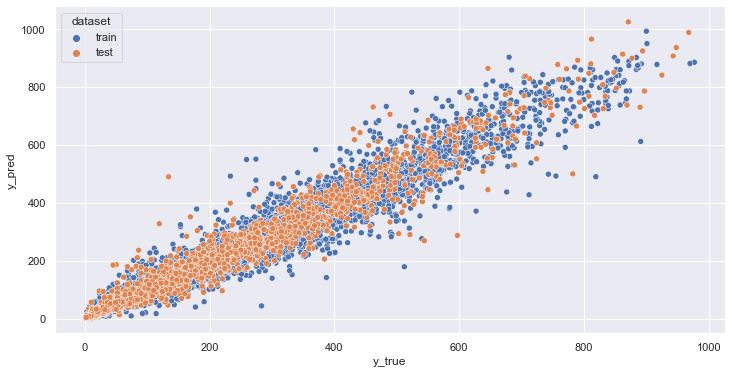

In [129]:
# Draw scatterplot of predictions vs. true values

df_res = pd.DataFrame(y_train)
df_res['y_pred']=y_pred_train
df_res['dataset']='train'
df_res.rename(columns = {'count' : 'y_true'}, inplace = True)

df_res2 = pd.DataFrame(y_test)
df_res2['y_pred']=y_pred_test
df_res2['dataset']='test'
df_res2.rename(columns = {'count' : 'y_true'}, inplace = True)

df_res = pd.concat([df_res, df_res2], ignore_index=True, sort=False)

#sns.relplot(x='y_true', y='y_pred', data=df_res, col='dataset', hue='dataset',height = 4)
plt.figure(figsize=(12,6))
sns.scatterplot(x='y_true', y='y_pred', hue='dataset', data=df_res)
sns.despine()


# RandomForest (separate models for casual and registered)

## Split data and transform y

In [27]:
# Define X and y
X = df_bike.drop(['casual', 'registered', 'count'], axis = 1)
y_cas = df_bike['casual']
y_reg = df_bike['registered']
y = df_bike[['casual', 'registered', 'count']]

In [28]:
#Train-test-split for casual bike shares
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 297)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8708, 13), (2178, 13), (8708, 3), (2178, 3))

In [29]:
# Derive required target variables for 'casual' and 'registered' bike counts
y_cas_train = y_train['casual']
y_reg_train = y_train['registered']

y_cas_test = y_test['casual']
y_reg_test = y_test['registered']

y_train = y_train['count']
y_test = y_test['count']

## Engineer features

_Same feature engineering as for linear regression with one model_

## Create regression model

### Model for 'casual'

In [30]:
rgr_rf_cas_t = TransformedTargetRegressor(regressor=RandomForestRegressor(n_estimators=200, max_depth=20), 
                                          func=np.log1p, inverse_func=np.expm1)

In [31]:
rgr_rf_cas_t.fit(X_train, y_cas_train);

In [32]:
round(rgr_rf_cas_t.score(X_train, y_cas_train), 3), round(rgr_rf_cas_t.score(X_test, y_cas_test), 3)

(0.983, 0.924)

### Model for 'registered'

In [33]:
rgr_rf_reg_t = TransformedTargetRegressor(regressor=RandomForestRegressor(n_estimators=200, max_depth=20),
                                          func=np.log1p, inverse_func=np.expm1)

In [34]:
rgr_rf_reg_t.fit(X_train, y_reg_train);

In [35]:
round(rgr_rf_reg_t.score(X_train, y_reg_train), 3), round(rgr_rf_reg_t.score(X_test, y_reg_test), 3)

(0.992, 0.955)

## Optimize hyperparameters

### Define parameters for the grid search

In [61]:
# Define parameters for hyperparameter optimization via GridSearch
parameters = {
    'regressor__n_estimators' : [50, 100, 400],
    'regressor__max_depth' : [5, 15, None],
    'regressor__max_features': ['auto', 'sqrt', 2],
    'regressor__min_samples_leaf' : [1, 2, 4],
}

### Model for 'casual'

In [62]:
cv_grd_h = GridSearchCV(estimator=rgr_rf_cas_t, 
                       param_grid=parameters, 
                       cv=3, scoring=rmsle_scorer,
                       n_jobs=-1)

In [63]:
cv_grd_h.fit(X_train, y_cas_train);

In [64]:
# Print results of hyperparameter optimization using grid search                
print_results(cv_grd_h, True)

Best:
-0.491  for  {'regressor__max_depth': None, 'regressor__max_features': 'auto', 'regressor__min_samples_leaf': 2, 'regressor__n_estimators': 400}
All:
-0.643  for {'regressor__max_depth': 5, 'regressor__max_features': 'auto', 'regressor__min_samples_leaf': 1, 'regressor__n_estimators': 50}
-0.641  for {'regressor__max_depth': 5, 'regressor__max_features': 'auto', 'regressor__min_samples_leaf': 1, 'regressor__n_estimators': 100}
-0.642  for {'regressor__max_depth': 5, 'regressor__max_features': 'auto', 'regressor__min_samples_leaf': 1, 'regressor__n_estimators': 400}
-0.641  for {'regressor__max_depth': 5, 'regressor__max_features': 'auto', 'regressor__min_samples_leaf': 2, 'regressor__n_estimators': 50}
-0.641  for {'regressor__max_depth': 5, 'regressor__max_features': 'auto', 'regressor__min_samples_leaf': 2, 'regressor__n_estimators': 100}
-0.642  for {'regressor__max_depth': 5, 'regressor__max_features': 'auto', 'regressor__min_samples_leaf': 2, 'regressor__n_estimators': 400}


In [66]:
rgr_rf_cas_best = cv_grd_h.best_estimator_

### Model for registered

In [67]:
cv_grd_h = GridSearchCV(estimator=rgr_rf_reg_t, 
                       param_grid=parameters, 
                       cv=3, scoring=rmsle_scorer,
                       n_jobs=-1)

In [68]:
cv_grd_h.fit(X_train, y_reg_train);

In [69]:
# Print results of hyperparameter optimization using grid search                
print_results(cv_grd_h, True)

Best:
-0.315  for  {'regressor__max_depth': None, 'regressor__max_features': 'auto', 'regressor__min_samples_leaf': 1, 'regressor__n_estimators': 400}
All:
-0.557  for {'regressor__max_depth': 5, 'regressor__max_features': 'auto', 'regressor__min_samples_leaf': 1, 'regressor__n_estimators': 50}
-0.555  for {'regressor__max_depth': 5, 'regressor__max_features': 'auto', 'regressor__min_samples_leaf': 1, 'regressor__n_estimators': 100}
-0.556  for {'regressor__max_depth': 5, 'regressor__max_features': 'auto', 'regressor__min_samples_leaf': 1, 'regressor__n_estimators': 400}
-0.555  for {'regressor__max_depth': 5, 'regressor__max_features': 'auto', 'regressor__min_samples_leaf': 2, 'regressor__n_estimators': 50}
-0.558  for {'regressor__max_depth': 5, 'regressor__max_features': 'auto', 'regressor__min_samples_leaf': 2, 'regressor__n_estimators': 100}
-0.555  for {'regressor__max_depth': 5, 'regressor__max_features': 'auto', 'regressor__min_samples_leaf': 2, 'regressor__n_estimators': 400}


In [70]:
# Define best rf regression model (also based on long table of results, complexity vs. score)
rgr_rf_reg_best = cv_grd_h.best_estimator_

## Evaluate regression model

_2 metrics used (R2 & RMSLE), RMSLE used for Kaggle competition_

### Using R2 - casual counts

In [71]:
r2_train = round(rgr_rf_cas_best.score(X_train, y_cas_train), 3)
print(f'R2 for train dataset: {r2_train}')

R2 for train dataset: 0.976


In [72]:
r2_test = round(rgr_rf_cas_best.score(X_test, y_cas_test), 3)
print(f'R2 for test dataset: {r2_test}')

R2 for test dataset: 0.921


In [73]:
# Cross validation with R2 as scorer
cross_val_r2 = cross_val_score(rgr_rf_cas_best, X_train, y_cas_train, 
                               cv=5, scoring='r2',
                               n_jobs=-1)
cross_val_r2

array([0.92066675, 0.90753389, 0.90429775, 0.91883665, 0.89429474])

In [74]:
# Mean R2 from cross-validation
round(cross_val_r2.mean(),3)

0.909

### Using R2 - registered counts

In [75]:
r2_train = round(rgr_rf_reg_best.score(X_train, y_reg_train), 3)
print(f'R2 for train dataset: {r2_train}')

R2 for train dataset: 0.992


In [76]:
r2_test = round(rgr_rf_reg_best.score(X_test, y_reg_test), 3)
print(f'R2 for test dataset: {r2_test}')

R2 for test dataset: 0.956


In [77]:
# Cross validation with R2 as scorer
cross_val_r2 = cross_val_score(rgr_rf_reg_best, X_train, y_reg_train, 
                               cv=5, scoring='r2',
                               n_jobs=-1)
cross_val_r2

array([0.95554467, 0.94345283, 0.94096385, 0.94724558, 0.93825251])

In [78]:
# Mean R2 from cross-validation
round(cross_val_r2.mean(),3)

0.945

### Using RMSLE - combined/counts

In [79]:
# Get predictions and ensure that all counts are non-negative (only for 'cas' model)
# casual
y_cas_pred_train = np.array([max(i, 0) for i in rgr_rf_cas_best.predict(X_train)])
y_cas_pred_test = np.array([max(i, 0) for i in rgr_rf_cas_best.predict(X_test)])
# registered
y_reg_pred_train = rgr_rf_reg_best.predict(X_train)
y_reg_pred_test = rgr_rf_reg_best.predict(X_test)

In [80]:
#Get predictions for train and test dataset
y_pred_train = y_cas_pred_train + y_reg_pred_train
y_pred_test = y_cas_pred_test + y_reg_pred_test

In [81]:
# RMSLE for train set
RMSLE_train = round(rmsle(y_train, y_pred_train), 3)
print(f'RMSLE for train dataset: {RMSLE_train}')

RMSLE for train dataset: 0.119


In [82]:
# RMSLE for train set
RMSLE_test = round(rmsle(y_test, y_pred_test), 3)
print(f'RMSLE for test dataset: {RMSLE_test}')

RMSLE for test dataset: 0.291


In [83]:
# Random cross-validation of combined model

# Make sure to use original train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 297)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

rmsle_list = []

for i in [12, 24, 44, 233, 53]:
    
    #Split the data set
    X_trn, X_tst, y_trn, y_tst = train_test_split(X_train, y_train, test_size=0.2, random_state=i)
    
    y_cas_trn = y_trn['casual']
    y_reg_trn = y_trn['registered']

    y_cas_tst = y_tst['casual']
    y_reg_tst = y_tst['registered']

    y_tst = y_tst['count']
    
    # Train the 2 models
    rgr_rf_cas_best.fit(X_trn, y_cas_trn)
    rgr_rf_reg_best.fit(X_trn, y_reg_trn)
    
    # Predict outcomes separately
    # ...casual counts
    y_cas_pred_tst = np.array([max(i, 0) for i in rgr_rf_cas_best.predict(X_tst)])
    # ...registered counts
    y_reg_pred_tst = rgr_rf_reg_best.predict(X_tst)
    
    # Combine predictions
    y_pred_tst = y_cas_pred_tst + y_reg_pred_tst

    # Calculate RMSLE score
    rmsle_i = rmsle(y_tst, y_pred_tst)
    
    # Save result
    rmsle_list.append(rmsle_i)
    
# Reset y_train values
y_train = y_train['count']
y_test = y_test['count']
    
# Print results
print('List of results: ', [round(i, 3) for i in rmsle_list])
print('Mean value: ', round(np.mean(rmsle_list), 3))

List of results:  [0.306, 0.319, 0.31, 0.312, 0.304]
Mean value:  0.31


### Check predictions vs. true values

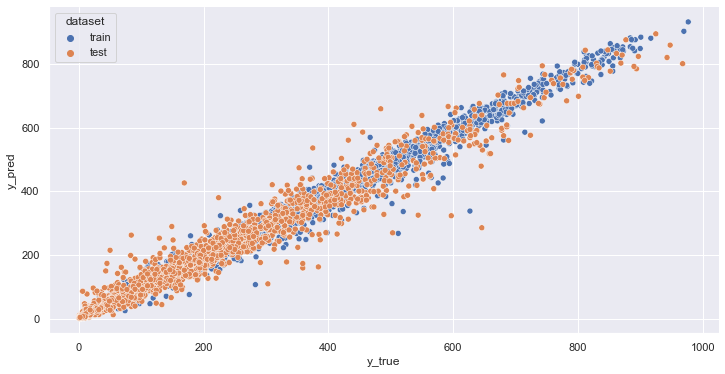

In [84]:
# Draw scatterplot of predictions vs. true values

df_res = pd.DataFrame(y_train)
df_res['y_pred']=y_pred_train
df_res['dataset']='train'
df_res.rename(columns = {'count' : 'y_true'}, inplace = True)

df_res2 = pd.DataFrame(y_test)
df_res2['y_pred']=y_pred_test
df_res2['dataset']='test'
df_res2.rename(columns = {'count' : 'y_true'}, inplace = True)

df_res = pd.concat([df_res, df_res2], ignore_index=True, sort=False)

#sns.relplot(x='y_true', y='y_pred', data=df_res, col='dataset', hue='dataset',height = 4)
plt.figure(figsize=(12,6))
sns.scatterplot(x='y_true', y='y_pred', hue='dataset', data=df_res)
sns.despine()


# Linear Regression and Random Forest sequentially combined

## Split the data

In [153]:
# Define X and y
X = df_bike.drop(['casual', 'registered', 'count'], axis = 1)
y = df_bike['count']

In [154]:
#Train-test-split for casual bike shares
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 297)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8708, 13), (2178, 13), (8708,), (2178,))

## Engineer features

### Define pipelines

_Pipelines can be reused_

### Summarize in column transformer

In [155]:
# Defining the "preprocessor" (using only 'timestamp related' data)
time_feature_transform = ColumnTransformer([
    ('one_hot_encoding', cat_pipe, ['year', 'month', 'day', 'hour']),
])

## Create and fit models

In [156]:
# Create linear regression model
rgr_lns = Pipeline(steps=[
            ('preprocessor', time_feature_transform),
            ('poly_features', PolynomialFeatures(degree=2, 
                                                 include_bias=False, 
                                                 interaction_only=False)),
            ('m_ln', LinearRegression())
])

rgr_lns_t = TransformedTargetRegressor(regressor=rgr_ln, func=np.log1p, inverse_func=np.expm1)

In [157]:
rgr_rfs = RandomForestRegressor(n_estimators=400, max_depth=10)

#rgr_rfs_t = TransformedTargetRegressor(regressor=RandomForestRegressor(), 
                                               #func=np.log1p, inverse_func=np.expm1)

In [158]:
rgr_lns_t.fit(X_train, y_train);

In [159]:
y_lns_pred_train = rgr_lns_t.predict(X_train)

In [160]:
y_rfs_train = y_train - y_lns_pred_train

In [161]:
rgr_rfs.fit(X_train, y_rfs_train)

RandomForestRegressor(max_depth=10, n_estimators=400)

In [162]:
y_rfs_pred_train = rgr_rfs.predict(X_train)

In [163]:
y_pred_train = y_lns_pred_train + y_rfs_pred_train
y_pred_train = [max(i, 0) for i in y_pred_train]

In [164]:
r2_score(y_train, y_pred_train)

0.9711286531820388

In [165]:
rmsle(y_train, y_pred_train)

0.2608554192964982

In [166]:
y_lns_pred_test = rgr_lns_t.predict(X_test)

In [167]:
y_rfs_pred_test = rgr_rfs.predict(X_test)

In [168]:
y_pred_test = [max(i, 0) for i in (y_lns_pred_test + y_rfs_pred_test)]

In [169]:
r2_score(y_test, y_pred_test)

0.9525762464236831

In [170]:
rmsle(y_test, y_pred_test)

0.30508110098595986

### Tune hyperparameters of randomforest model

_Currently done manually - automation to be added_

## Evaluate model

In [171]:
# Random cross-validation of combined model

rmsle_list = []

for i in [12, 24, 44, 233, 53]:
    
    #Split the data set
    X_trn, X_tst, y_trn, y_tst = train_test_split(X_train, y_train, test_size=0.2, random_state=i)
    
    # Train linear model
    rgr_lns_t.fit(X_trn, y_trn)
    
    # Predict outcomes of linear model
    y_lns_pred_trn = rgr_lns_t.predict(X_trn)
    
    # Transform target variable for randomforest
    y_rfs_trn = y_trn - y_lns_pred_trn
    
    # Train RandomForest model
    rgr_rfs.fit(X_trn, y_rfs_trn)
    
    # Predict test data with linear model
    y_lns_pred_tst = rgr_lns_t.predict(X_tst)
        
    # Predict deviations with RandomForest
    y_rfs_pred_tst = rgr_rfs.predict(X_tst)
    
    # Combine model results
    y_pred_tst = [max(i, 0) for i in (y_lns_pred_tst + y_rfs_pred_tst)]
    
    # Calculate rmsle
    rmsle_i = rmsle(y_tst, y_pred_tst)
    
    # Save result in list
    rmsle_list.append(rmsle_i)
    
# Print results
print('List of results: ', [round(i, 3) for i in rmsle_list])
print('Mean value: ', round(np.mean(rmsle_list), 3))

List of results:  [0.339, 0.343, 0.323, 0.337, 0.308]
Mean value:  0.33


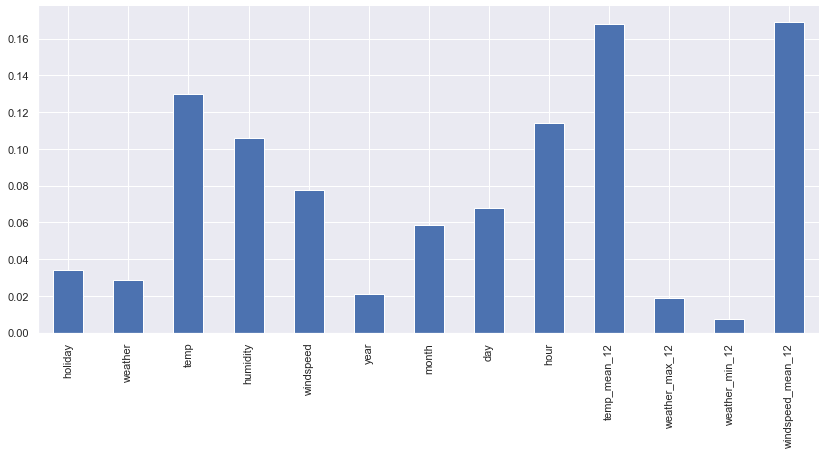

In [172]:
# Analyze feature importance
importance = pd.DataFrame(rgr_rfs.feature_importances_)
importance.index = X.columns
importance.sort_values(by = 0, ascending = False).head(10)

importance.plot.bar(legend=False, figsize=(14,6))
sns.despine()

# Submission to Kaggle

## Import data

In [173]:
# Get test.data
X_test_kaggle = pd.read_csv('/Users/philipwitte/Documents/spiced_projects/fenugreek-student-code/week03/data/test.csv', 
                            index_col=0,
                            parse_dates=True)
X_test_kaggle.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
datetime,,,,,,,,
2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [174]:
X_test_kaggle.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6493 entries, 2011-01-20 00:00:00 to 2012-12-31 23:00:00
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      6493 non-null   int64  
 1   holiday     6493 non-null   int64  
 2   workingday  6493 non-null   int64  
 3   weather     6493 non-null   int64  
 4   temp        6493 non-null   float64
 5   atemp       6493 non-null   float64
 6   humidity    6493 non-null   int64  
 7   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5)
memory usage: 456.5 KB


## Add additional features

### Add time related features

In [175]:
X_test_kaggle = X_test_kaggle.reset_index()

In [176]:
# Year
X_test_kaggle['year'] = X_test_kaggle['datetime'].apply(lambda x: x.year)

In [177]:
# Month
X_test_kaggle['month'] = X_test_kaggle['datetime'].apply(lambda x: x.month)

In [178]:
# Day of the week
X_test_kaggle['day'] = X_test_kaggle['datetime'].apply(lambda x: x.isoweekday())

In [179]:
# Hour within day
X_test_kaggle['hour'] = X_test_kaggle['datetime'].apply(lambda x: x.hour)

In [180]:
X_test_kaggle = X_test_kaggle.set_index('datetime')

### Add 'rolling' mean/min/max features

In [181]:
# mean of temp of previous 3 and 12 hours
X_test_kaggle['temp_mean_12'] = X_test_kaggle['temp'].rolling(12).mean().fillna(method='bfill')

In [182]:
# max of weather of previous 3 and 12 hours
X_test_kaggle['weather_max_12'] = X_test_kaggle['weather'].rolling(12).max().fillna(method='bfill')

In [183]:
# min of weather of previous 3 and 12 hours
X_test_kaggle['weather_min_12'] = X_test_kaggle['weather'].rolling(12).min().fillna(method='bfill')

In [184]:
# mean of wind of previous 3 and 12 hours
X_test_kaggle['windspeed_mean_12'] = X_test_kaggle['windspeed'].rolling(12).mean().fillna(method='bfill')

### Drop correlated columns

In [185]:
X_test_kaggle = X_test_kaggle.drop(['workingday', 'season', 'atemp'], axis = 1)

### Check data

In [186]:
X_test_kaggle.head(3)

,holiday,weather,temp,humidity,windspeed,year,month,day,hour,temp_mean_12,weather_max_12,weather_min_12,windspeed_mean_12
datetime,,,,,,,,,,,,,
2011-01-20 00:00:00,0,1,10.66,56,26.0027,2011,1,4,0,10.181667,2.0,1.0,13.167733
2011-01-20 01:00:00,0,1,10.66,56,0.0000,2011,1,4,1,10.181667,2.0,1.0,13.167733
2011-01-20 02:00:00,0,1,10.66,56,0.0000,2011,1,4,2,10.181667,2.0,1.0,13.167733


## Predict count

In [187]:
# Predict and merge the data
# Current classifier used: LinearRegression
y_pred_kaggle = rgr_ln_t.predict(X_test_kaggle)
y_pred_kaggle = X_test_kaggle.reset_index()[['datetime']].join(pd.DataFrame(y_pred_kaggle, columns = ['count']))
y_pred_kaggle.set_index('datetime', inplace = True)
y_pred_kaggle

,count
datetime,
2011-01-20 00:00:00,10.056425
2011-01-20 01:00:00,4.932642
2011-01-20 02:00:00,3.181455
2011-01-20 03:00:00,1.838085
2011-01-20 04:00:00,1.664527
...,...
2012-12-31 19:00:00,369.631131
2012-12-31 20:00:00,255.385815
2012-12-31 21:00:00,214.786555


In [188]:
y_pred_kaggle.to_csv('submission.csv')

# My sandbox (to be deleted at end of week)

In [ ]:
from sklearn import set_config
from sklearn import set_config
set_config(display='diagram')
rgr_ln_t

In [ ]:
1) GRA DI ENT
2) CON VER GING
3) GLO BAL MI NI MUM
4) DI VER GING
5) LOC AL MI NI MUM
6) LOSS FUNC TI ON
7) PARA MET ER SPA CE

In [ ]:
df_bike.loc['2011-07-01':'2011-07-31',['casual', 'registered']].plot(figsize=(12,6))
sns.despine()

In [ ]:
df_bike['2011-1']

In [ ]:
# Basic correlograms
sns.pairplot(df_bike.drop(['temp', 'atemp', 'humidity', 'windspeed'], axis = 1))
plt.show()

In [ ]:
sns.pairplot(df_bike[['temp', 'atemp', 'humidity', 'windspeed', 'count']])
plt.show()

In [ ]:
# Train calssification model

# Import relevant modules and functionailties 
# Diable warnings
import warnings
warnings.filterwarnings('ignore')
# Imputing
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
# Scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
# Ordinal
from sklearn.preprocessing import OrdinalEncoder
# OneHot
from sklearn.preprocessing import OneHotEncoder
# Bins
from sklearn.preprocessing import KBinsDiscretizer
# Customized transformer
from sklearn.preprocessing import FunctionTransformer
# Pipelines
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
# Column transformer
from sklearn.compose import ColumnTransformer
# Polynomial Features
from sklearn.preprocessing import PolynomialFeatures
#Classifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier  
# Cross-validation
from sklearn.model_selection import cross_val_score

In [ ]:
df_clf = df_bike.resample('1d').mean().dropna()

In [ ]:
X = df_clf.drop(['casual', 'registered', 'count', 'hour', 'year'], axis = 1)
y = df_clf[['casual']]

In [ ]:
bins = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
y_trans = bins.fit_transform(y)

In [ ]:
m_rfc = RandomForestClassifier(n_estimators=100, max_depth=5)
m_rfc.fit(X, y_trans)

In [ ]:
cross_val_score(m_rfc, X, y_trans, cv = 5, scoring='accuracy')

In [ ]:
importance = pd.DataFrame(m_rfc.feature_importances_)
importance.index = X.columns
importance.sort_values(by = 0, ascending = False).head(10)

importance.plot.bar(legend=False)
sns.despine()

In [ ]:
#Draw everything - 1 week
plt.figure(figsize=(15,8))
sns.lineplot(data=df_bike.loc['2011-07-01' : '2011-07-07'], markers=True)

plt.xticks(rotation=15)
plt.ylabel('All features')
plt.xlabel('Date')

plt.title('Al features - 1 week')

plt.show()

In [ ]:
#Draw everything - 1 day
plt.figure(figsize=(15,8))
sns.lineplot(data=df_bike.loc['2011-07-01'], markers=True)

plt.xticks(rotation=15)
plt.ylabel('All features')
plt.xlabel('Date')

plt.title('All features - 1 day')

plt.show()

In [ ]:
## Typical day in January

In [ ]:
#time_period = pd.date_range('1 January 2011', '19 January 2011', freq='1h') # does not work, idx data missing

df_jan11 = df_bike.loc['1 January 2011' : '20 January 2011']
df_jan11 = df_jan11.groupby(df_jan11.index.hour).mean()
df_jan11.tail()

In [ ]:
plt.figure(figsize=(15,8))
sns.lineplot(data=df_jan11, markers=True)

plt.xticks(rotation=15)
plt.ylabel('All features')
plt.xlabel('Date')

plt.title('All features, hourly mean - day in January')

plt.show()

In [ ]:
df_bike.resample('1D').mean().loc['2011-01-01':'2011-01-19']['count'].plot()
sns.despine()

In [ ]:
# Different way to select a time period
time_period = pd.date_range('1 July 2011', periods = 19)
df_period = df_bike.loc[time_period]
df_period.tail() 

In [ ]:
# Group by weekdays - option 1
df_day_names = df_period.groupby(df_period.index.day_name()).mean()
df_day_names.sort_index()

In [ ]:
df_day_names['day_id'] = df_day_names.index
dict={'Monday' : '1', 
      'Tuesday' : '2', 
      'Wednesday' : '3', 
      'Thursday' : '4', 
      'Friday' : '5', 
      'Saturday' : '6',
      'Sunday' : '7'}

def day_id(x):
    for day, idx in dict.items():
        x = str(x).replace(day, idx)
    return x

df_day_names['day_id'] = df_day_names['day_id'].apply(day_id)

df_day_names.sort_values(by='day_id', inplace = True)

In [ ]:
df_day_names['count'].plot()
sns.despine()

In [ ]:
# Group by weekdays option 2
df_day_names = df_period.groupby(df_period.index.weekday).mean()
df_day_names['weekday'] = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_day_names.set_index('weekday', inplace = True)
df_day_names

In [ ]:
df_day_names['count'].plot()
sns.despine()

In [ ]:
# Idea: group by mean temperature per day and see dependency on count
period_july = pd.date_range('1 July 2011', periods=19)
data = df_bike.resample('1D').max().loc[period_july, ['temp','count']]
data.rename(columns = {'temp' : 'max_temp', 'count' : 'max_count'}, inplace = True)

In [ ]:
plt.figure(figsize=(10,8))
ax = data['max_count'].plot(legend = True, ylabel = 'Count')
ax.set_ylim(350,650)
ax2 = data['max_temp'].plot(secondary_y = True, legend = True)
ax2.set_ylim(30,50)
ax2.set_ylabel(ylabel = 'Temperature [C°]')

# To plot with seaborn
#ax = sns.lineplot(data = data['count'], color = 'r', legend = 'full')
#ax2 = sns.lineplot(data = data['temp'], ax=ax.twinx() , color ='g', legend = 'full')
#ax.set_ylabel('Count', color = 'r')
#ax2.set_ylabel('Temperatur', color = 'g')

sns.despine()

In [ ]:
# Temperature vs. Count
plt.figure(figsize=(14,6))
ax1 = df_bike.loc['2011-07','temp'].resample('1d').mean().plot(legend=True)
ax2 = df_bike.loc['2011-07','count'].resample('1d').mean().plot(secondary_y = True, legend =True)

ax1.set_ylabel('Temperature [C°]')
ax2.set_ylabel('Count [pieces]')

sns.despine()

In [ ]:
# copied from: https://github.com/scikit-learn/scikit-learn/issues/12525

def get_column_names_from_ColumnTransformer(column_transformer):    
    col_name = []

    for transformer_in_columns in column_transformer.transformers_[:-1]: #the last transformer is ColumnTransformer's 'remainder'
        #print('\n\ntransformer: ', transformer_in_columns[0])
        
        raw_col_name = list(transformer_in_columns[2])
        
        if isinstance(transformer_in_columns[1], Pipeline): 
            # if pipeline, get the last transformer
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
            
        try:
          if isinstance(transformer, OneHotEncoder):
            names = list(transformer.get_feature_names(raw_col_name))
            
          elif isinstance(transformer, SimpleImputer) and transformer.add_indicator:
            missing_indicator_indices = transformer.indicator_.features_
            missing_indicators = [raw_col_name[idx] + '_missing_flag' for idx in missing_indicator_indices]

            names = raw_col_name + missing_indicators
            
          else:
            names = list(transformer.get_feature_names())
          
        except AttributeError as error:
          names = raw_col_name
        
        #print(names)    
        
        col_name.extend(names)
            
    return col_name

In [ ]:
import json

def is_answer(node):
    return len(node) == 1


with open('questions.json') as f:
    node = json.load(f)

finished = False

while not finished:

    if is_answer(node):
        finished = True
    else:
        print(node['text'])
        while 1: 
            answer = input()
            if answer.lower() in ['yes', 'y']:
                node = node['yes']
                break
            elif answer.lower() in ['no', 'n']:
                node = node['no']
                break
            else: 
                print('please try again (yes/no)')